In [47]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [36]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "05_Utilities") ## full path to the "05_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing ## modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting ## modul for mel-spectrogram visualization
import sharedValues ## modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
#processAudio = processAudio()
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()

In [37]:
# import data from selected dataset

audio_datasets = []
audio_datasets_main_dir_path = None

def access_data_from_local_system():
    global audio_datasets_main_dir_path, audio_datasets
    cwd = str(Path.cwd())
    parent_dir = os.path.dirname(cwd)
    audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
    audio_datasets_main_dir_path = os.path.join(parent_dir, audio_datasets_main_dir)

    if os.path.exists(audio_datasets_main_dir_path):
        for i in os.listdir(audio_datasets_main_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets.append(i)
        audio_datasets = sorted(audio_datasets)
    else:
        print("Audio dataset directory does not exist")

    return audio_datasets

audio_datasets = access_data_from_local_system()

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [38]:
# import data from selected test directory

dataset_id = 1 # ID of the selected datasets, 1 - ethernet, 3 - hva 280, 5 - hva 630

long_window = False
if dataset_id == 2:
    long_window = True

def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

noise_dataset_id = 6
noise_dataset_augmented_id = 3

loaded_spec_chunks = None
loaded_spec_chunk_labels = None

dataset_dir_path = os.path.join(audio_datasets_main_dir_path, audio_datasets[dataset_id])

file_list = []
for f in os.listdir(dataset_dir_path):
    if f.endswith('.npz'):
        file_list.append(f)

test_files_sorted = sorted(file_list, key=sort_key_func)

print(test_files_sorted[:5])

"""if len(test_files_sorted) == 0:
    print(f"No .npz file in the directory {audio_datasets[dataset_id]}")
else:
    loaded_spec_chunks_list = []
    loaded_spec_chunk_labels_list = []

    for file in test_files_sorted:
        file_fullpath = os.path.join(dataset_dir_path, file)
        dataset = np.load(file_fullpath)
        
        # Append each file's data to the lists
        loaded_spec_chunks_list.append(dataset['spec_chunks'])
        loaded_spec_chunk_labels_list.append(dataset['labels'])"""

['ethernet_test_1_dataset.npz', 'ethernet_test_2_dataset.npz', 'ethernet_test_3_dataset.npz', 'ethernet_test_4_dataset.npz', 'ethernet_test_5_dataset.npz']


'if len(test_files_sorted) == 0:\n    print(f"No .npz file in the directory {audio_datasets[dataset_id]}")\nelse:\n    loaded_spec_chunks_list = []\n    loaded_spec_chunk_labels_list = []\n\n    for file in test_files_sorted:\n        file_fullpath = os.path.join(dataset_dir_path, file)\n        dataset = np.load(file_fullpath)\n        \n        # Append each file\'s data to the lists\n        loaded_spec_chunks_list.append(dataset[\'spec_chunks\'])\n        loaded_spec_chunk_labels_list.append(dataset[\'labels\'])'

In [ ]:
"""print(f"Number of files: {len(loaded_spec_chunks_list)}")
print(f"Number of labels: {len(loaded_spec_chunk_labels_list)}")

print(f"Shape of the first file's data: {loaded_spec_chunks_list[0].shape}")
print(f"Shape of the first file's label: {loaded_spec_chunk_labels_list[0].shape}")"""

Number of files: 30
Number of labels: 30
Shape of the first file's data: (162, 128, 32)
Shape of the first file's label: (162,)


In [ ]:
# normalize spectrogram chunks

def normalize_spectrogram_chunks(spec_chunks):
    # global min and max values for dB range
    global_min = -120
    global_max = 0

    # convert to numpy array
    spec_chunks = np.array(spec_chunks)

    # normalize to the range [0, 1]
    normalized_spectrograms = (spec_chunks - global_min) / (global_max - global_min)

    return normalized_spectrograms

"""loaded_spec_chunks_list_norm = []
for spec_chunks in loaded_spec_chunks_list:
    spec_chunks_norm = normalize_spectrogram_chunks(spec_chunks)
    loaded_spec_chunks_list_norm.append(spec_chunks_norm)

print(len(loaded_spec_chunks_list_norm))
print(loaded_spec_chunks_list_norm[0].shape)
print(np.min(loaded_spec_chunks_list_norm[0]), np.max(loaded_spec_chunks_list_norm[0]))"""

30
(162, 128, 32)
0.0 1.0


In [39]:
# import detection model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

selected_model = "ClickDetectorCNN_64_64.py"

model_architectures_dir = "03_Click_Detection_Model/01_modelArchitectures"
model_architectures_dir_path = os.path.join(parent_dir, model_architectures_dir)
print(model_architectures_dir_path)

if os.path.exists(model_architectures_dir_path):
    sys.path.append(model_architectures_dir_path)
    model_module = importlib.import_module(selected_model[:-3])
    #from ClickDetectorCNN_v1 import ClickDetectorCNN
    ClickDetectorCNN = getattr(model_module, 'ClickDetectorCNN') #access the ClickDetectorCNN class
    model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
else:
    print("Model architectures directory does not exist")

model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
model

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/03_Click_Detection_Model/01_modelArchitectures


ClickDetectorCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [40]:
# loda model weights

model_weights_dir = "03_Click_Detection_Model/02_savedWeights"
model_weights_dir_path = os.path.join(parent_dir, model_weights_dir)

model_weights = "ethernet_det_model_run_0_ch1_64_ch2_64.pt"
model_weights_full_path = os.path.join(model_weights_dir_path, model_weights)

if os.path.exists(model_weights_full_path):
    model.load_state_dict(torch.load(model_weights_full_path, map_location=device, weights_only=True)) # load model weights, map location of weights to device
    model.to(device)
    print("Model weights have been loaded")
    print(f"model: {model}")
else:
    print("Model weights file does not exist")

Model weights have been loaded
model: ClickDetectorCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


In [50]:
if len(test_files_sorted) == 0:
    print(f"No npz file in the directory {audio_datasets[dataset_id]}")
else:
    file_fullpath = os.path.join(dataset_dir_path, test_files_sorted[0])

    data = np.load(file_fullpath)
    loaded_spec_chunks = data['spec_chunks']
    loaded_spec_chunk_labels = data['labels']

print(f"Number of labels: {len(loaded_spec_chunk_labels)}")
print(f"Shape of the first file's data: {loaded_spec_chunks.shape}")
print(f"Type of the first file's data: {type(loaded_spec_chunks)}")
print(f"Shape of the first file's label: {loaded_spec_chunk_labels.shape}")
print(f"Type of the first file's label: {type(loaded_spec_chunk_labels)}")
print(f"positive samples: {np.count_nonzero(loaded_spec_chunk_labels == 1)}")
print(f"negative samples: {np.count_nonzero(loaded_spec_chunk_labels == 0)}")

Number of labels: 162
Shape of the first file's data: (162, 128, 32)
Type of the first file's data: <class 'numpy.ndarray'>
Shape of the first file's label: (162,)
Type of the first file's label: <class 'numpy.ndarray'>
positive samples: 5
negative samples: 157


In [52]:
spec_chunks_norm = normalize_spectrogram_chunks(loaded_spec_chunks)

print(spec_chunks_norm.shape)
print(f"type of spec_chunks_norm: {type(spec_chunks_norm)}")
print(np.min(spec_chunks_norm[0]), np.max(spec_chunks_norm[0]))

(162, 128, 32)
type of spec_chunks_norm: <class 'numpy.ndarray'>
0.0793392817179362 1.0


In [61]:
def to_tensor(X, y):
    X = torch.from_numpy(X).type(torch.float32).unsqueeze(1) # convert to torch and add channel dimension
    y = torch.from_numpy(y).type(torch.float32)
    return X, y

X, y = to_tensor(spec_chunks_norm, loaded_spec_chunk_labels)

print(X.shape)
print(y.shape)

torch.Size([162, 1, 128, 32])
torch.Size([162])


In [62]:
BATCH_SIZE = len(X)
test_dataset = torch.utils.data.TensorDataset(X, y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of test dataloader: {len(test_loader)}")
test_features_batch, test_labels_batch = next(iter(test_loader))
test_features_batch.shape, test_labels_batch.shape

Length of test dataloader: 1


(torch.Size([162, 1, 128, 32]), torch.Size([162]))

In [65]:
test_loss, test_acc = 0, 0

all_preds = []
all_true_labels = []

binary_threshold = 0.5

def accuracy_fn(y_true, y_pred):
        binary_predictions = (y_pred > binary_threshold).float()
        correct = torch.eq(y_true, binary_predictions).sum().item() # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100
        return acc

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        # forward pass
        test_pred = model(X)
        test_pred = torch.squeeze(test_pred)

        # calculate accuracy
        binary_predictions = (test_pred > binary_threshold).float()

        test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        all_preds.extend(binary_predictions.tolist())
        all_true_labels.extend(y.tolist())

    # divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_loader)

    # divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_loader)

print(f"Test acc: {test_acc:.2f}%\n")

Test acc: 95.68%



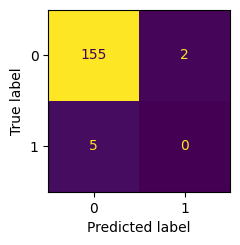

In [66]:
# plot out confusion matrix

width_cm = 6
height_cm = 6
cm_to_inch = 2.54

fig_cm, ax_cm = plt.subplots(figsize=(width_cm/cm_to_inch, height_cm/cm_to_inch))

cm = confusion_matrix(all_true_labels, all_preds)

disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax_cm, cmap = None, colorbar=False)

plt.show()

In [75]:
# number of true positives and true negatives

false_positive_indices = len([i for i, (pred, true) in enumerate(zip(all_preds, all_true_labels)) if pred == 1.0 and true == 0.0])
false_negative_indices = [i for i, (pred, true) in enumerate(zip(all_preds, all_true_labels)) if pred == 0.0 and true == 1.0]
true_positive_indices = [i for i, (pred, true) in enumerate(zip(all_preds, all_true_labels)) if pred == 1.0 and true == 1.0]
true_negative_indices = [i for i, (pred, true) in enumerate(zip(all_preds, all_true_labels)) if pred == 0.0 and true == 0.0]

print("Indices of false positives:", false_positive_indices)
print("Indices of false negatives:", false_negative_indices)
print("true positives:", len(true_positive_indices))
print("Indices of true negatives:", len(true_negative_indices))

Indices of false positives: 2
Indices of false negatives: [91, 92, 93, 94, 95]
true positives: 0
Indices of true negatives: 155


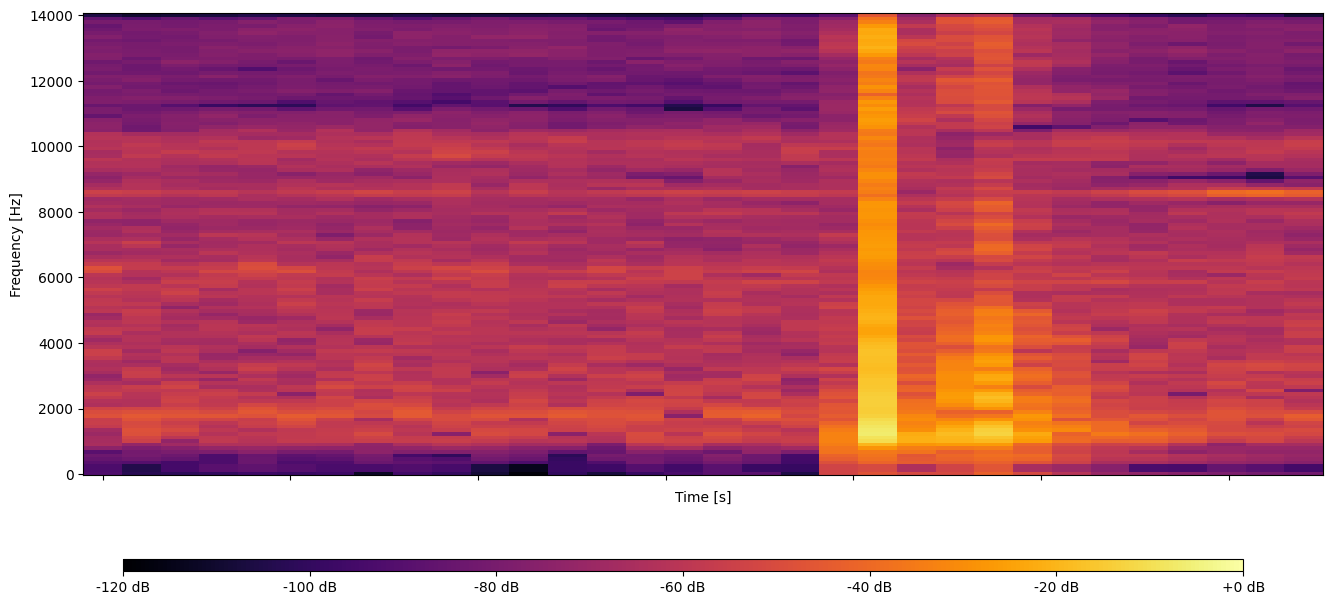

In [71]:
# plot out one spectrogram chunk
chunk_to_plot_id = 92
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value
f_min = sharedValuesConfig.F_MIN ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX ## maximum frequency in Hz
n_mels = sharedValuesConfig.N_MELS ## number of mel bands (rows in the mel-scaled spectrogram)
spectrogramPlotter.plot_single_mel_spectrogram(loaded_spec_chunks[chunk_to_plot_id], top_dB_abs, f_min, f_max, n_mels)